In [96]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fkplotlib
import cmocean
import pdb

def linreg(x, y):
    a = np.cov(x, y, rowvar=False, ddof=1)[0, 1] / np.var(x, ddof=1)
    b = np.mean(y) - a * np.mean(x)
    return a, b

def decorrelate(toi_raw):
    med = np.nanmedian(toi_raw, axis=0) # Compute TOI medians
    gs = np.nanmean(toi_raw / med[np.newaxis, :], axis=1) # Compute gains
    gs[np.isnan(gs)] = 1.0
    cm = np.nanmean(gs[:, np.newaxis] * med[np.newaxis, :], axis=0) # Common mode
    #pdb.set_trace()
    toi_decorr = []
    for toi in toi_raw:    
        # Linear regression of CM to measure noise
        a, b = linreg(cm, toi)
        noise = a * cm + b
        toi_decorr.append(toi - noise)
    return cm, np.array(toi_decorr)

In [129]:
t = Table.read("Data/calibrated_toi_2mm_20180122s309.fits")
#t = Table.read("calibrated_toi_2mm_20180115s89.fits")
t = t[sorted(t.colnames)]

# TOIs

In [130]:
w_time = range(2000, 12000, 1)
w_kids_cm = range(len(t.colnames))

off = 50.0
toi_raw = np.array([t.columns[k][w_time] for k in w_kids_cm]) + off
cm, toi_decorr = decorrelate(toi_raw)

<IPython.core.display.Javascript object>


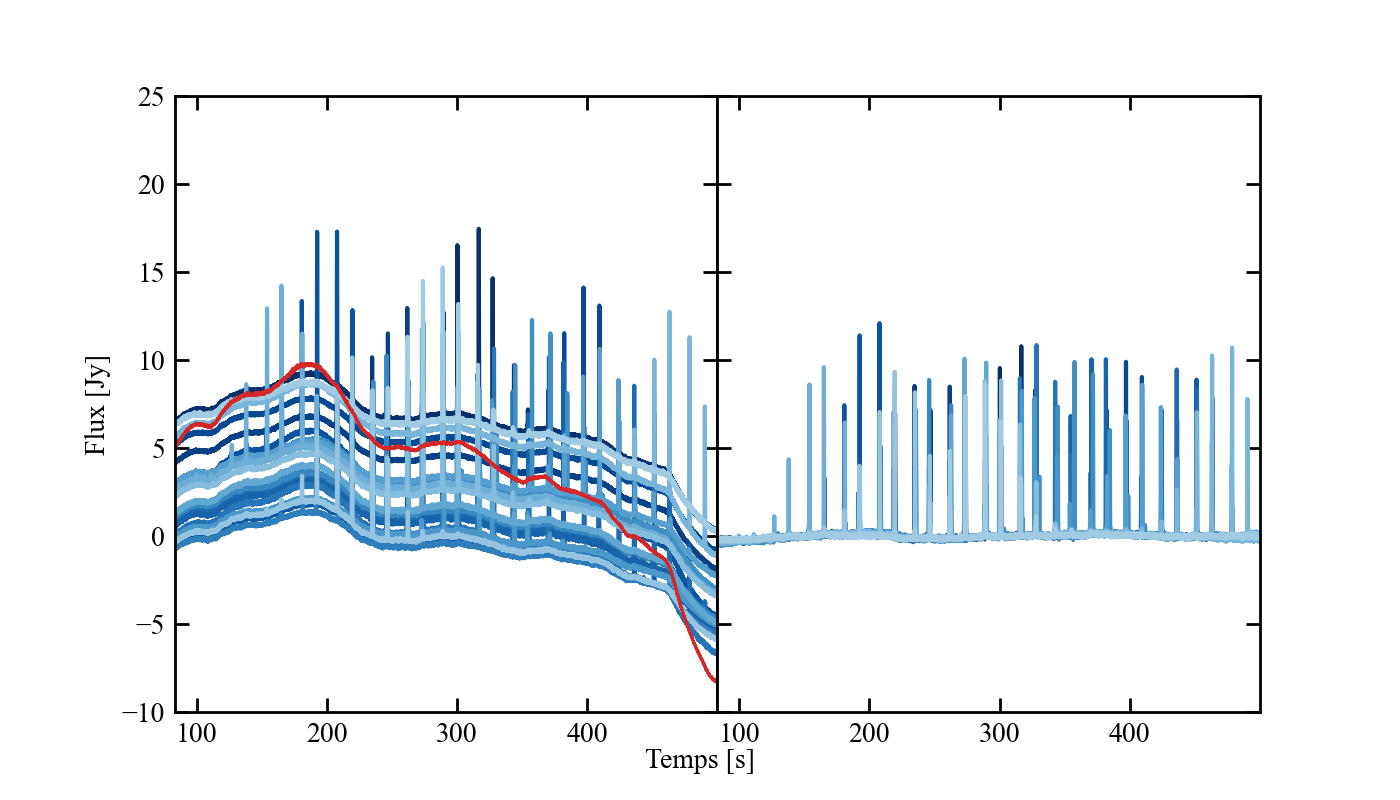

In [135]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
w_kids = range(10, 30)
time = np.array(w_time) / 24.0
for i, k in enumerate(w_kids):
    color = plt.cm.Blues_r(i / (1.5*len(w_kids)))
    #color = cmocean.cm.ice(i / len(w_kids))
    axs[0].plot(time, toi_raw[k] - off, lw=1.5, color=color)
    axs[1].plot(time, toi_decorr[k], lw=1.5, color=color)
    
axs[0].plot(time, cm - off, color="tab:red")
axs[1].set_yticklabels([])
for ax in axs:
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(-10, 25)
    #ax.set_xticks(np.arange(0, len(med), 2500))
    #ax.set_xticklabels([])
    fkplotlib.ax_bothticks(ax)
fig.subplots_adjust(wspace=0)
axs[0].set_ylabel("Flux [Jy]")
fig.text(0.5, 0.04, "Temps [s]", ha="center")

fig.savefig("toi.pdf")

# Correlation matrices

In [115]:
from scipy.io import readsav
s = readsav("Data/corr_before.save")
corr_before = s["m"]
del s
s = readsav("Data/corr_after.save")
corr_after = s["m"]
del s

<IPython.core.display.Javascript object>


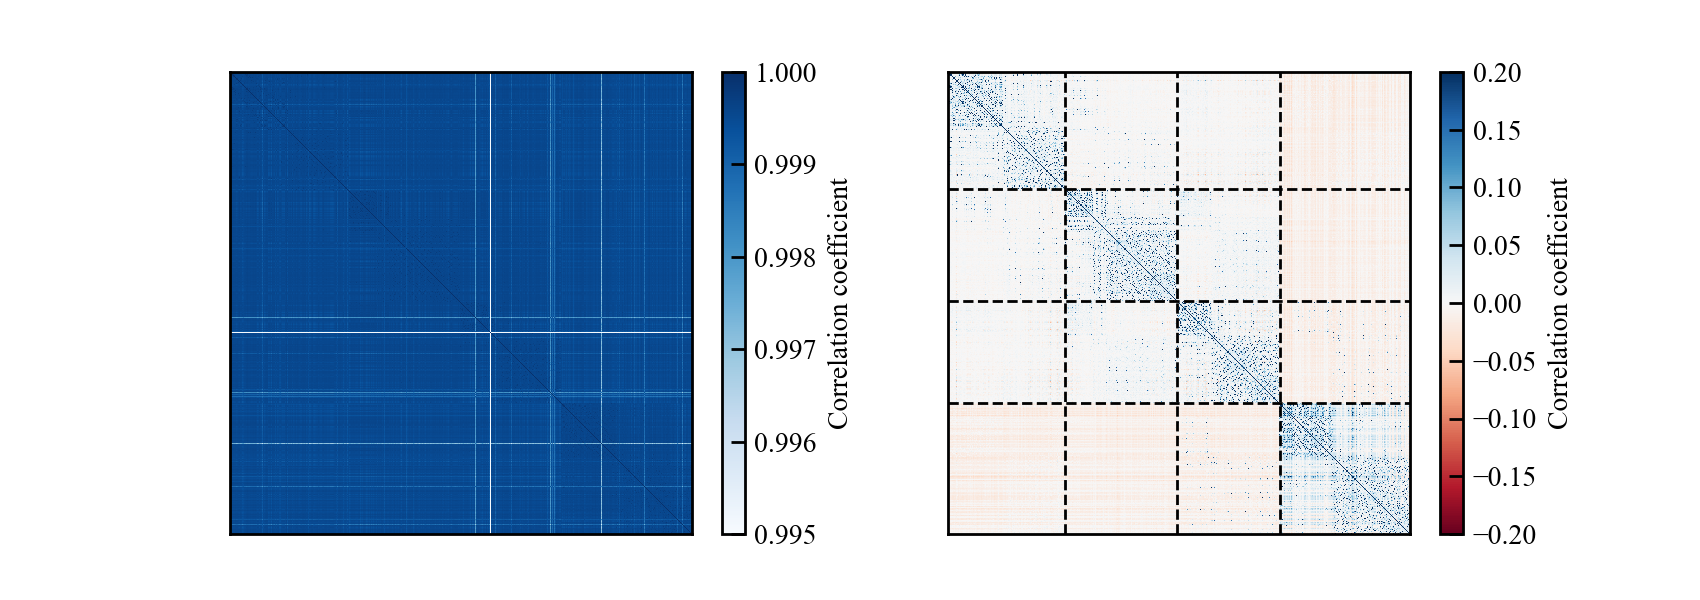

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 3))
im = axs[0].matshow(corr_before, vmin=0.995, vmax=1, cmap="Blues")
cb = fig.colorbar(im, ax=axs[0])
cb.set_label("Correlation coefficient")

im = axs[1].matshow(corr_after, vmin=-0.2, vmax=0.2, cmap="RdBu")
cb = fig.colorbar(im, ax=axs[1])
cb.set_label("Correlation coefficient")

#lines = [i for i in range(len(t.colnames)) if (t.colnames[i][1] != t.colnames[i-1][1])]
lines = [122, 239, 346]
for line in lines:
    axs[1].axhline(line, 0, 1, color="k", ls="--")
    axs[1].axvline(line, 0, 1, color="k", ls="--")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig("toi_correlation.pdf")